<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/TPMLGymQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning
## Appliqué à [Gym.OpenAI](https://gym.openai.com)

---
## Présentation de Gym

Voir la page d'introduction à [Gym](https://gym.openai.com).

### Installation de gym

#### Outil AUTRE QUE COLAB (pyzo, jupyter lab, .....)

In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.8 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym

---
- Utiliser l'environnement `FrozenLake en mode 8x8 en mode texte` (un labyrinthe)
  - il est possible d'utiliser cet environnement en mode 'slipery', alors appliquer une *action n'est pas déterministe !*
    - à partir d'une case "gelée", aller à droite peut .. mener à droite, ou en haut ou en bas....
    - => intérêt du Q-Learning adapté à ce type d'environnement probabiliste
- Le labyrinthe est ainsi composé de zones glacées, de puits, et d'un objectif contenant une récompense


**N.B.**
  - *Cet environnement fonctionne bien sous colab, jupyterlab.. quelques soucis de l'affichage de l'état courant (carré rouge) sous Pyzo....*
  - Il est fortement conseillé de débuter avec un environnement déterministe pour évaluer la bonne marche de l'algo de Q-Learning que vous aurez développer..

---
#### Etude de l'environnement

In [ ]:
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='ansi')
# tester map_name="8x8" pour l'environnement plus large
print(env.spec)
print(env.action_space) #ici 4 actions discrétisée
print(env.observation_space) # ici 4x4 cellules possibles

env.reset()
print(env.render())
print("S = Start, G = Goal, H = Hole, F = Frozen place")

EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'map_name': '8x8', 'is_slippery': True, 'render_mode': 'ansi'}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)
Discrete(4)
Discrete(64)

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

S = Start, G = Goal, H = Hole, F = Frozen place


---
#### Test des actions

En mode non déterministe, chaque action a 1 chance sur 3 de réussir..<br>
*Exemple aller à droite mène 1/3 à droite, 1/3 en haut, 1/3 en bas.*

In [ ]:
###### Test des fonctions
env.reset()
action = 0
observation, reward, done, _, info = env.step(action)
print(env.render())
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 0 ,gain: 0.0 ,fini: False , {'prob': 0.3333333333333333}


In [ ]:
env.reset()
action = 1
observation, reward, done, _, info = env.step(action)
print(env.render())
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 0 ,gain: 0.0 ,fini: False , {'prob': 0.3333333333333333}


In [ ]:
env.reset()
action = 2
observation, reward, done, _, info = env.step(action)
print(env.render())
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 0 ,gain: 0.0 ,fini: False , {'prob': 0.3333333333333333}


In [ ]:
env.reset()
action = 3
observation, reward, done, _, info = env.step(action)
print(env.render())
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 0 ,gain: 0.0 ,fini: False , {'prob': 0.3333333333333333}


In [ ]:
env.observation_space.n

64

In [ ]:
env.action_space.n

4

In [ ]:
#note :
## observation = position où se trouve l'agent (no case(i,j) = i*largeur+j)
## reward = recompense
## done = but atteint
## truncated = etat feuille (non utilise ici)
## info = proba de reussite de l'action

On est clairement ici dans un environnement non déterministe (une même action à partir d'un même état ne mène pas toujours au même résultat); c'est le contexte de prédilection de l'algo de Q-Learning...

---
### <font color="red">Mise en place de l'environnement en mode déterministe</font>
Important, pour valider l'apprentissage de votre algorithme avant de passer en mode non-déterministe, il vaut mieux le tester sur un environnement où chaque action à 100% de réussite. Ci-dessous un exemple sur le mini labyrinthe.

In [ ]:
#env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=False, render_mode='ansi')
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=False)

In [ ]:
actions = [2,2,1,1,1,2]
env.reset()
for a in actions:
    observation, reward, done, info = env.step(a)
    print(env.render(mode='ansi'))
    print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 1 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 2 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 10 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 18 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 26 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

pos° actuelle: 27 ,gain: 0.0 ,fini: False , {'prob': 1.0}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


---
***Aide Python : (plusieurs possibilités)***
- Il n'est pas nécessaire de créer des classes Etat, ....
- Il faut pouvoir stocker les récompenses de chaque actions à partir de chaque case
  - a priori, la création d'une matrice 4x4 de 4 valeurs peut être utile.
  Plus simplement, on utilisera un tableau de n cases (pour les n etats) contenant m valeurs d'actions
  

In [ ]:
import numpy as np
# cree un tableau de n cases x m actions
q_actions = np.zeros((env.observation_space.n, env.action_space.n), np.float32)
print(q_actions)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


*Recherche du max et de sa position*

Reprenons la derniere modélisation sous forme de tableau de 4 valeurs.

In [ ]:
#Exemple de recherche..
#1. ici pour l'exemple, on place des valeurs aléatoires pour les actions
Q = np.random.random((env.observation_space.n, env.action_space.n))
print(Q)

[[0.69115084 0.51442959 0.47866507 0.54892589]
 [0.0286918  0.29454903 0.78172127 0.41935362]
 [0.70693679 0.74389921 0.18763399 0.44694909]
 [0.47753321 0.51464229 0.73720244 0.93860758]
 [0.19226942 0.20727305 0.46042321 0.7032247 ]
 [0.28243358 0.62776639 0.19293299 0.92773199]
 [0.29364698 0.30415547 0.00124631 0.49444144]
 [0.28168183 0.31089985 0.74091096 0.09144758]
 [0.81924084 0.0711232  0.9299047  0.16040526]
 [0.13336345 0.69120743 0.94724785 0.98853859]
 [0.08223202 0.27532671 0.74607748 0.61631451]
 [0.68451817 0.16456981 0.27607034 0.26107573]
 [0.87098905 0.95816805 0.67550213 0.12067768]
 [0.8465684  0.99512489 0.48074086 0.73988538]
 [0.39239715 0.31786533 0.95024552 0.02397693]
 [0.87809095 0.04935643 0.02502925 0.46299073]
 [0.050098   0.87971251 0.61126169 0.69206642]
 [0.07095557 0.98086019 0.81225285 0.9223858 ]
 [0.06447826 0.55639838 0.57148228 0.9910494 ]
 [0.98003896 0.1440267  0.15594991 0.2822954 ]
 [0.29658531 0.48710139 0.72917539 0.73674482]
 [0.16228368 

In [ ]:
#max de la case 2
max_2 = np.max(Q[2, :])
position_max_2 = np.argmax(Q[2,:])
print("case 2, max=",max_2, ", en position ", position_max_2)
print("la meilleure action de l'etat 2 serait donc ", position_max_2)

case 2, max= 0.7438992120728162 , en position  1
la meilleure action de l'etat 2 serait donc  1


  -----
# Développer la solution en Q-Learning

Pour rappel, l'algorithme de Q-Learning est le suivant :

- Initialiser la table des poids des arcs :
  - $\forall s \forall a Q(s,a) \gets 0$
- Pour n boucles d'apprentissage
  - $\lambda \gets 1 ; \epsilon \gets 1 ;$
  - $etat Courant \gets  etat initial$
  - Pour n' itérations ( n' = nombre max supposé d'actions pour atteindre l'objectif)
    - $s \gets  etat Courant$
    - $nb \gets random(0,1)$
    - Si $nb < \epsilon$ Alors
      - Choisir aléatoirement une action a
    - Sinon
      - Choisir action la plus intéressante : $a \gets argMax_{a'}(Q(s,a'))$
    - Fin Si
    - Effectuer action a :
    - $s' \gets  nouvel Etat Courant$
    - calculer $Q(s,a) \gets \lambda \times (r + \gamma \times max_{a'}(Q(s', a')) + (1-\lambda ) \times Q(s,a)$
    - {{decrémenter}} les coefficients d'apprentissage et d'exploration :
      - $\lambda \gets 0.99 \times \lambda$
      - $\epsilon \gets 0.99 \times \epsilon$
    - Si but atteint, casser la boucle n' (uniquement celle là)
  - Fin pour n' itérations
- Fin pour n boucles d'apprentissage  

En reprenant les définitions précédentes, $Q(s,a)$ est équivalent à `Q[s][a]`

## Initialisation des variables

On utilisera initialement les affectations suivantes pour les variables :
- variables d'exploration, de récompense et d'apprentissage :
  - $ \lambda \gets 0.8$
  - $ \gamma \gets 0.998$
- nombre de cycles :
  - $ n \gets 10000$ si grille 4x4, 50000 si grille 8x8
  - $ n' \gets 10$ si grille 4x4, 20 si grille 8x8
    
----    

 #### Q-Learning simple

In [ ]:
import random as rnd
epsilon = 1.0  # Stratégie d'exploration-exploitation
lambda_learn = 0.3  # Taux d'apprentissage
gamma = 0.9  # Facteur de remise

def q_learn(nb_actions):
    s = env.reset()
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    while not done and step < nb_actions:
        step += 1
        if rnd.random() < epsilon or np.all(Q[s, :] == 0):
            a = rnd.randint(0, env.action_space.n - 1)
        else:
            a = np.argmax(Q[s, :])

        new_state, r, done, _ = env.step(a)

        Q[s, a] += lambda_learn * (r + gamma * np.max(Q[new_state, :]) - Q[s, a])

        s = new_state
        total_r += r
        states_list.append(s)
        actions_list.append(a)

    return total_r, r, states_list, actions_list

def try_qlearn(nb_episodes=4000, nb_actions=64):
    global epsilon 
    solutions_list = []
    for i in range(nb_episodes):
        total_r, r, states_list, actions_list = q_learn(nb_actions)
        epsilon *= 0.999
        if r == 1:
            solutions_list.append((i, total_r, states_list, actions_list))

    if not solutions_list:
        print("aucune solution trouvée !!")

    return solutions_list


def rendu(solutions_list):
    if solutions_list:
        mini_sol = min(solutions_list, key=lambda x: len(x[2]))
        print(f"Une solution en {len(mini_sol[2])} étapes : ")
        env.reset()
        for a in mini_sol[3]:
            _, _, done,_ = env.step(a)
            print(f"\nAction {a}\n")
            print(env.render(mode='ansi'))
            if done:
                break
    else:
        print("Aucune solution trouvée !!")

In [ ]:
lambda_learn = 0.3
gamma = 0.9
Q = np.zeros((env.observation_space.n, env.action_space.n))


max_attempts = 10000
attempt = 0
solutions = []

while not solutions and attempt < max_attempts:
    epsilon = 1.0
    solutions = try_qlearn(2000, 50)
    attempt += 1 
    print(f"Tentative {attempt}: {len(solutions)} solutions trouvées.")

    if solutions:
        rendu(solutions)
        break
    else:
        print("Aucune solution n'a été trouvée, nouvelle tentative...")

if not solutions:
    print("Aucune solution n'a été trouvée après l'apprentissage malgré les multiples tentatives.")

aucune solution trouvée !!
Tentative 1: 0 solutions trouvées.
Aucune solution n'a été trouvée, nouvelle tentative...
Tentative 2: 398 solutions trouvées.
Une solution en 14 étapes : 

Action 2

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 2

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 2

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 2

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 2

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 1

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 2

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 1

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 2

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
F

----
**Etudions l'historique**

In [ ]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.show()

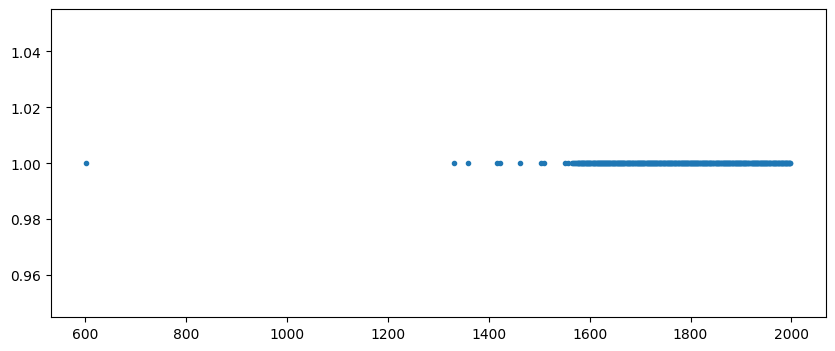

In [ ]:
plot_frequence_sol(solutions)

In [ ]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "ecrase" les valeurs pour réduire leurs différences (utile pour le choix des couleurs)
    bestQValues = [max(ligne)**(1/10) for ligne in Q]
    dim = int(Q.shape[0]**(1/2))
    #on transforme bestQValues en matrice dim x dim
    bestQValues = np.reshape(bestQValues, (dim,dim))
    #on demande à python de générer une "heatmap"
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

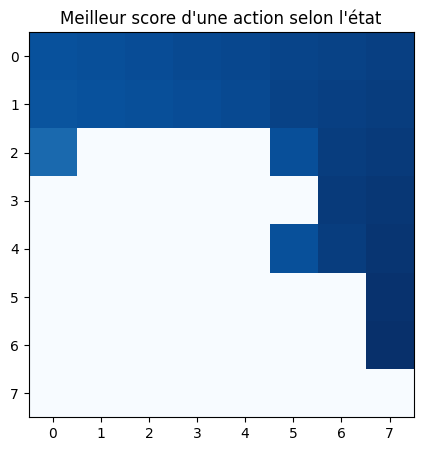

In [ ]:
showBestValues(Q)

---
## L'algorithme de Double Q-Learning

#### Explication du double Q-Learning
L'algo de **double** Q-Learning simple repose sur DEUX matrices nb_etats x nb_actions; la mise à jour des valeurs d'une action dans une grille utilise la valeur de la meilleure action suivante dans l'autre matrice.

On réalise, plus ou moins alternativement :

$a^* \gets  argmax_{a} QA(s', a)$,

$QA(s,a) \gets QA(s,a) + \lambda \times (r + \gamma \times QB(s', a^*))-  QA(s,a))$

ou

$b^* \gets  argmax_{a} QB(s', a)$

$QB(s,a) \gets QB(s,a) + \lambda \times (r + \gamma \times QA(s', b^*))-  QB(s,a))$

avec
  - $\lambda$ : coef. d'apprentissage
  - $\gamma$ : coef. de réduction
  - $r$ : récompense
  
Cette équation donne la qualité de l'action *a* à partir de l'état *s*.

Initialement, à chaque état, une action est choisie aléatoirement (car toutes "valent" 0); puis au fil des tests les actions les plus valuées sont choisies.

*Vous pouvez voir en fin de cette page des aides sur les fonctionnalités Python utiles pour la manipulation de tableaux.*

#### Initialisation

#double q learning (Déterministe)

In [ ]:
import numpy as np
import gym
import random

env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=False)

Q1 = np.random.random((env.observation_space.n, env.action_space.n))
Q2 = np.random.random((env.observation_space.n, env.action_space.n))

In [ ]:
def q_learn_double(nb_actions, Q1, Q2, epsilon):
    s = env.reset()
    if isinstance(s, tuple):
        s = s[0] 
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    lambda_learn = .3
    gamma = 0.9
    while not done and step < nb_actions:
        step += 1
        if random.random() < epsilon:
            a = random.randint(0, env.action_space.n - 1)
        else:
            a = np.argmax(Q1[s] + Q2[s])

        new_state, r, done, _ = env.step(a)[0:4]

        if random.random() < 0.5:
            best_next_action = np.argmax(Q1[new_state])
            td_target = r + gamma * Q2[new_state, best_next_action]
            Q1[s, a] = (1 - lambda_learn) * Q1[s, a] + lambda_learn * (td_target)
        else:
            best_next_action = np.argmax(Q2[new_state])
            td_target = r + gamma * Q1[new_state, best_next_action]
            Q2[s, a] = (1 - lambda_learn) * Q2[s, a] + lambda_learn * (td_target)

        s = new_state
        total_r += r
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list

def try_qlearn_double(nb_episodes=4000, nb_actions=64):
    solutions_list = []
    epsilon = 1
    for i in range(nb_episodes):
        total_r, r, states_list, actions_list = q_learn_double(nb_actions, Q1, Q2, epsilon)
        epsilon *= 0.999
        if r == 1: solutions_list.append((i, total_r, states_list, actions_list))
    return solutions_list

def rendu(solutions_list):
    if len(solutions_list) > 0:
        mini_sol = min(solutions_list, key=lambda x: len(x[2]))
        print(f"Une solution en {len(mini_sol[2])} étapes :")

        state = env.reset()
        env.render()

        for a in mini_sol[3]:
            state, _, done, _ = env.step(a)
            print(f"\naction {a}\n")
            out = env.render(mode='ansi')
            print(out.strip())

            if done:
                break
    else:
        print("Aucune solution trouvée !!")

In [ ]:
solutions = try_qlearn_double(2000, 50)

if len(solutions) > 0:
    rendu(solutions)
else:
    print("Aucune solution n'a été trouvée après l'apprentissage.")


Aucune solution n'a été trouvée après l'apprentissage.


In [ ]:
max_attempts = 10000
attempt = 0
solutions = []

while not solutions and attempt < max_attempts:
    epsilon = 1.0
    solutions = try_qlearn_double(2000, 50)
    attempt += 1
    print(f"Tentative {attempt}: {len(solutions)} solutions trouvées.")

    if solutions:
        rendu(solutions)
        break
    else:
        print("Aucune solution n'a été trouvée, nouvelle tentative...")

if not solutions:
    print("Aucune solution n'a été trouvée après l'apprentissage malgré les multiples tentatives.")

Tentative 1: 0 solutions trouvées.
Aucune solution n'a été trouvée, nouvelle tentative...
Tentative 2: 1 solutions trouvées.
Une solution en 19 étapes :

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 1

(Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 1

(Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FF

In [ ]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "ecrase" les valeurs pour réduire leurs différences (utile pour le choix des couleurs)
    bestQValues = [max(ligne)**(1/10) for ligne in Q]
    dim = int(Q.shape[0]**(1/2))
    #on transforme bestQValues en matrice dim x dim
    bestQValues = np.reshape(bestQValues, (dim,dim))
    #on demande à python de générer une "heatmap"
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


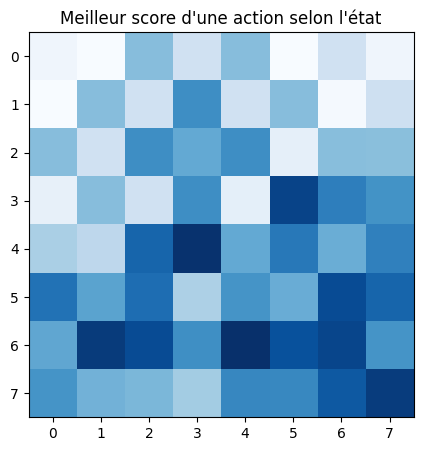

In [ ]:
showBestValues(Q1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


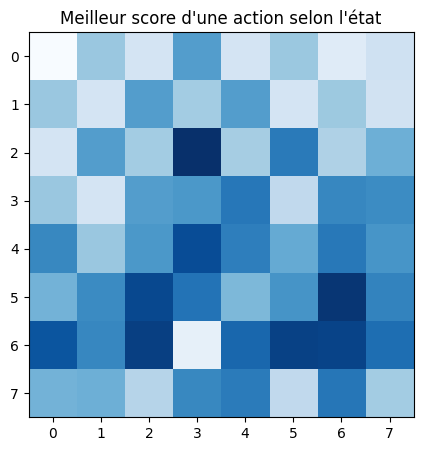

In [ ]:
showBestValues(Q2)

#double q learning (Non déterministe)

In [ ]:
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True)

Q1 = np.random.random((env.observation_space.n, env.action_space.n))
Q2 = np.random.random((env.observation_space.n, env.action_space.n))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def q_learn_double(nb_actions, Q1, Q2, epsilon):
    s = env.reset()
    if isinstance(s, tuple):
        s = s[0] 
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    lambda_learn = .3
    gamma = 0.9
    while not done and step < nb_actions:
        step += 1
        if random.random() < epsilon:
            a = random.randint(0, env.action_space.n - 1)
        else:
            a = np.argmax(Q1[s] + Q2[s])

        new_state, r, done, _ = env.step(a)[0:4]

        if random.random() < 0.5:
            best_next_action = np.argmax(Q1[new_state])
            td_target = r + gamma * Q2[new_state, best_next_action]
            Q1[s, a] = (1 - lambda_learn) * Q1[s, a] + lambda_learn * (td_target)
        else:
            best_next_action = np.argmax(Q2[new_state])
            td_target = r + gamma * Q1[new_state, best_next_action]
            Q2[s, a] = (1 - lambda_learn) * Q2[s, a] + lambda_learn * (td_target)

        s = new_state
        total_r += r
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list

def try_qlearn_double(nb_episodes=4000, nb_actions=64):
    solutions_list = []
    epsilon = 1
    for i in range(nb_episodes):
        total_r, r, states_list, actions_list = q_learn_double(nb_actions, Q1, Q2, epsilon)
        epsilon *= 0.999
        if r == 1: solutions_list.append((i, total_r, states_list, actions_list))
    return solutions_list

def rendu(solutions_list):
    if len(solutions_list) > 0:
        mini_sol = min(solutions_list, key=lambda x: len(x[2]))
        print(f"Une solution en {len(mini_sol[2])} étapes :")

        state = env.reset()
        env.render()

        for a in mini_sol[3]:
            state, _, done, _ = env.step(a)
            print(f"\naction {a}\n")
            out = env.render(mode='ansi')
            print(out.strip())

            if done:
                break
    else:
        print("Aucune solution trouvée !!")

In [ ]:
max_attempts = 10000
attempt = 0
solutions = []

while not solutions and attempt < max_attempts:
    epsilon = 1.0
    solutions = try_qlearn_double(2000, 50)
    attempt += 1
    print(f"Tentative {attempt}: {len(solutions)} solutions trouvées.")

    if solutions:
        rendu(solutions)
        break
    else:
        print("Aucune solution n'a été trouvée, nouvelle tentative...")

if not solutions:
    print("Aucune solution n'a été trouvée après l'apprentissage malgré les multiples tentatives.")

Tentative 1: 3 solutions trouvées.
Une solution en 18 étapes :


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



action 1

(Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 3

(Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 3

(Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 3

(Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 1

(Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 3

(Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 2

(Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 1

(Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 1

(Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 1

(Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

action 1

(Down

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.xlabel("no du test")
    plt.ylabel("gain")
    plt.title("Fréquence d'apparition de solution")
    plt.show()


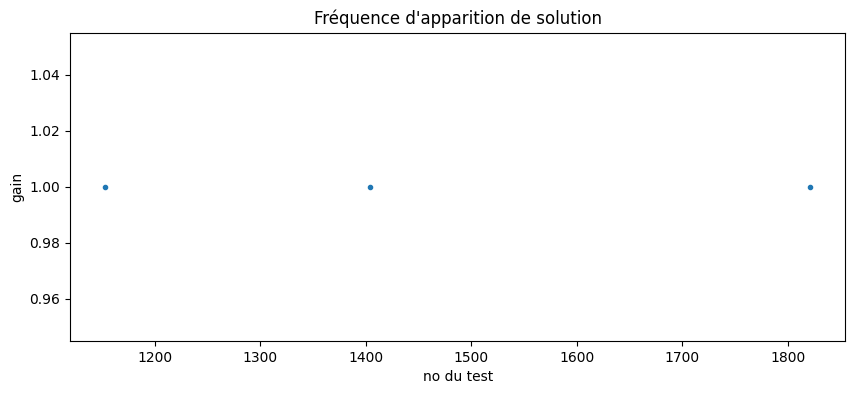

In [ ]:
plot_frequence_sol(solutions)

In [ ]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "ecrase" les valeurs pour réduire leurs différences (utile pour le choix des couleurs)
    bestQValues = [max(ligne)**(1/10) for ligne in Q]
    dim = int(Q.shape[0]**(1/2))
    #on transforme bestQValues en matrice dim x dim
    bestQValues = np.reshape(bestQValues, (dim,dim))
    #on demande à python de générer une "heatmap"
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


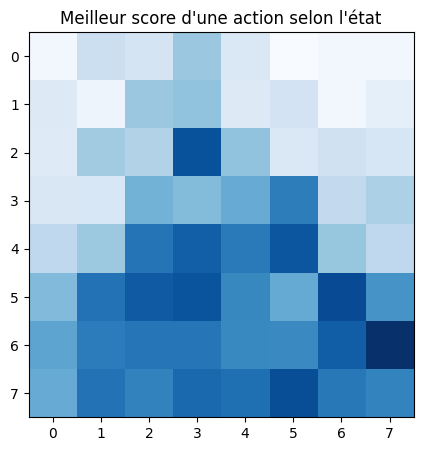

In [ ]:
showBestValues(Q1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


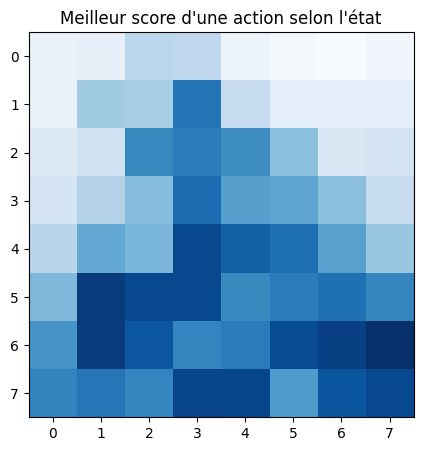

In [ ]:
showBestValues(Q2)

#comparaison de performance

In [ ]:
epsilon = 1.0 

def q_learn_double(env, Q1, Q2, nb_actions, epsilon):
    s = env.reset()
    total_r = 0
    done = False
    actions_list = []
    states_list = []
    lambda_learn = 0.3
    gamma = 0.9

    for _ in range(nb_actions):
        if random.random() < epsilon:
            a = random.randint(0, env.action_space.n - 1)
        else:
            a = np.argmax(Q1[s] + Q2[s])

        new_state, r, done, _ = env.step(a)

        if random.random() < 0.5:
            best_next_action = np.argmax(Q1[new_state])
            td_target = r + gamma * Q2[new_state, best_next_action]
            Q1[s, a] = (1 - lambda_learn) * Q1[s, a] + lambda_learn * td_target
        else:
            best_next_action = np.argmax(Q2[new_state])
            td_target = r + gamma * Q1[new_state, best_next_action]
            Q2[s, a] = (1 - lambda_learn) * Q2[s, a] + lambda_learn * td_target

        s = new_state
        total_r += r
        states_list.append(s)
        actions_list.append(a)
        if done:
            break

    return total_r, states_list, actions_list


In [ ]:
def try_qlearn_double(env, Q1, Q2, nb_episodes=4000, nb_actions=64):
    performances = []
    global epsilon
    for episode in range(nb_episodes):
        total_r, states_list, actions_list = q_learn_double(env, Q1, Q2, nb_actions, epsilon)
        epsilon *= 0.999  # Diminuer epsilon pour augmenter l'exploitation au fil du temps
        performances.append((episode, total_r, states_list))
    return performances

In [ ]:
import numpy as np
import gym
import random

def setup_environment(mode='non-deterministe'):
    if mode == 'deterministe':
        env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=False)
    else: 
        env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True)

    Q1 = np.random.random((env.observation_space.n, env.action_space.n))
    Q2 = np.random.random((env.observation_space.n, env.action_space.n))

    return env, Q1, Q2


def analyse_performances(performances):
    if performances:
        moyenne_etapes = sum(len(states_list) for _, _, states_list in performances) / len(performances)
        moyenne_recompenses = sum(total_r for _, total_r, _ in performances) / len(performances)
        print(f"Moyenne des étapes pour atteindre l'objectif: {moyenne_etapes}")
        print(f"Moyenne des récompenses: {moyenne_recompenses}")
        print(f"Nombre de solutions trouvées: {len(performances)}")
    else:
        print("Aucune performance à analyser.")



# Configuration et test pour le mode déterministe
env, Q1, Q2 = setup_environment('deterministe')
performances_deterministe = try_qlearn_double(env, Q1, Q2, 2000, 50)

# Configuration et test pour le mode non-déterministe
env, Q1, Q2 = setup_environment('non-deterministe')
performances_nondeterministe = try_qlearn_double(env, Q1, Q2, 2000, 50)

# Analyse des performances
print("Performances en mode déterministe :")
analyse_performances(performances_deterministe)

print("\nPerformances en mode non-déterministe :")
analyse_performances(performances_nondeterministe)



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Performances en mode déterministe :
Moyenne des étapes pour atteindre l'objectif: 10.5865
Moyenne des récompenses: 0.0005
Nombre de solutions trouvées: 2000

Performances en mode non-déterministe :
Moyenne des étapes pour atteindre l'objectif: 17.4655
Moyenne des récompenses: 0.001
Nombre de solutions trouvées: 2000


#### Travail à faire
- Codez le double q learning dans une fonction proche de celle décrite pour le Q-Learning.
- Reprenez la suite des fonctions développée pour lancer une résolution en mode déterministe et non déterministe.
- Comparez les performances  (1ere solution trouvée, fréquence des solutions, ...)
- reprenez au choix le simple QLearning, ou le Double Q-Learning et appliquez l'algorithme sur l'environnement CliffWalking-v0 (point de départ en x, arrivée en T, coût de -1 par action sur o, -100 par action sur C).
   
```o  o  o  o  o  o  o  o  o  o  o  o```

```o  o  o  o  o  o  o  o  o  o  o  o```

```o  o  o  o  o  o  o  o  o  o  o  o```

```x  C  C  C  C  C  C  C  C  C  C  T```


In [ ]:
import numpy as np
import gym
import random as rnd

In [ ]:
env = gym.make('CliffWalking-v0')
#solution = politique = suite d'actions menant à un but
actions = [0,1,1,1,1,1,1,1,1,1,1,1,2]
env.reset()
for a in actions:
    observation, reward, done, info = env.step(a)
    print(env.render(mode='ansi'))
    print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 24 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 25 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 26 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 27 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 28 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o 

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
env = gym.make('CliffWalking-v0', render_mode='ansi')
#env = gym.make('CliffWalking-v0')
actions = {0:'Haut', 1:'Droite', 2:'Bas', 3:'Gauche'}

In [ ]:
lambda_learn = .2
gamma = 0.99
epsilon = 1.

In [ ]:
QA = np.zeros([env.observation_space.n,env.action_space.n])
QB = np.zeros([env.observation_space.n,env.action_space.n])

In [ ]:
##algorithme de Q-Learning simple
def q_learn(nb_actions=64):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees
    goal : but atteint

    """
    s = env.reset()
    if isinstance(s, tuple):
        s = s[0]  # Prend le premier élément si c'est un tuple
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []

    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actionsA = QA[s, :]
        actionsB = QB[s, :]
        if rnd.random()<epsilon :
            a = rnd.randint(0, env.action_space.n-1)
        else:
            bestQa = np.argmax(actionsA)
            bestQb = np.argmax(actionsB)
            a = bestQa if QA[s, bestQa] > QB[s, bestQb] else bestQb

        # Get new state and reward from environment
        new_state, r, done, _ = env.step(a)


        # Q-Learning
        if (np.random.uniform(0.1) < 0.5):
            aeto= np.argmax(QA[new_state, :])
            QA[s, a] = QA[s, a] + lambda_learn*(r + gamma * QB[new_state,aeto] - QA[s, a])
        else:
            beto=np.argmax(QB[new_state,:])
            QB[s, a] = QB[s, a] + lambda_learn*(r + gamma * QA[new_state,beto] - QB[s, a])

        s = new_state
        total_r = total_r + r
        states_list.append(s)
        actions_list.append(a)

    return total_r, r, states_list, actions_list, done

In [ ]:
def try_qlearn(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon

    solutions_list = []
    epsilon = 1
    for i in range(nb_episodes):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list, done = q_learn(nb_actions)
        epsilon = epsilon * 0.9999
        # memorize if a solution has been found
        if done: solutions_list.append((i, total_r, states_list, actions_list))

    if (len(solutions_list) == 0): print("aucune solution trouvee !!")
    return solutions_list


In [ ]:
def rendu(solutions_list):
    """Affiche la plus courte séquence d'actions permettant d'atteindre l'objectif à partir des solutions fournies."""
    if not solutions_list:
        print("Aucune solution disponible.")
        return

    mini_sol = min(solutions_list, key=lambda x: len(x[2]))  # Trouver la solution avec le moins d'étapes
    print(f"Une solution en {len(mini_sol[2])} étapes :")

    state = env.reset()
    out = env.render()
    if isinstance(out, list):
        out = "".join(out) 
    print(out.strip())

    for action_index in mini_sol[3]:
        action_name = actions[action_index]
        print(f"Action {action_name}")
        state, _, done, _ = env.step(action_index)
        out = env.render()
        if isinstance(out, list):
            out = "".join(out)
        print(out.strip())
        if done:
            break


In [ ]:
solutions = try_qlearn(15000, 50)
if(len(solutions)>0):rendu(solutions)

Une solution en 13 étapes :
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T
Action Haut
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T
Action Droite
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T
Action Droite
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T
Action Droite
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T
Action Droite
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T
Action Droite
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  

In [ ]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.show()

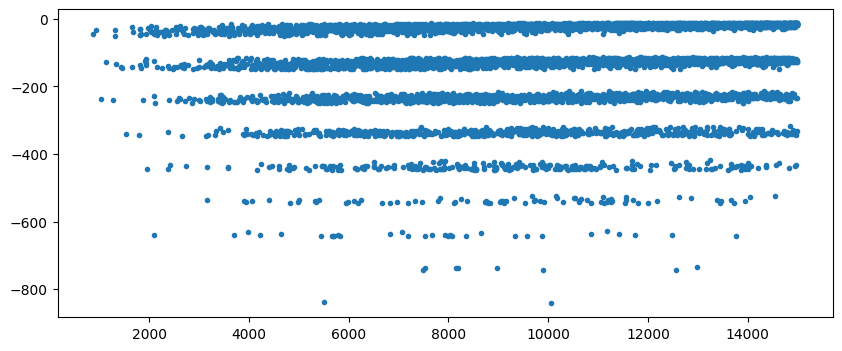

In [ ]:
plot_frequence_sol(solutions)

In [ ]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "dilate" les valeurs pour augmenter leurs différences (utile pour le choix des couleurs)
    bestQ = [-(max(ligne))**50 for ligne in Q]
    #on transforme bestQValues en matrice 4 x 12
    bestQValues = np.reshape(bestQ, (4,12))
    #on demande à python de générer une "heatmap"
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

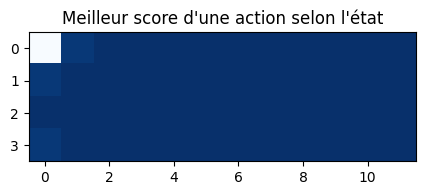

In [ ]:
showBestValues(QA)

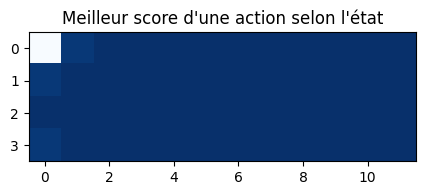

In [ ]:
showBestValues(QB)